# (Dataset Exploration Title)
## by Andrew Shannon

Churn analysis
https://www.charlesbordet.com/en/how-to-predict-ltv-saas-startup/#

Plotting in for loops
https://medium.com/@rayheberer/generating-matplotlib-subplots-programmatically-cc234629b648

## Preliminary Wrangling

> This document explores the Telco customer churn data set from Kaggle.  This data consists of 7043 customers described by 21 variables.

https://www.kaggle.com/blastchar/telco-customer-churn

To Do:
1.  Survival analysis: for churn and impactful variables
https://lifelines.readthedocs.io/en/latest/Quickstart.html
https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e
2.  Document everything I did

In [54]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter

%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

> Load in your dataset and describe its properties through the questions below.
Try and motivate your exploration goals through this section.

In [3]:
df = pd.read_csv("telco_customer_churn.csv")
df = df[df['tenure'] != 0]

In [4]:
df['tenure_years'] = (df.tenure / 12).astype(int)

In [5]:
# High level overview of data

print(df.shape)
print(df.dtypes)

(7032, 22)
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
tenure_years          int64
dtype: object


In [6]:
df = df.replace({'No phone service': 'No', 'No internet service': 'No', r'\s+': 'trash'}, regex=True)
df['SeniorCitizen'] = df.SeniorCitizen.replace({0: 'No', 1: 'Yes'})
df['TotalCharges'] = df.TotalCharges.astype('float')

In [7]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_years
0,7590-VHVEG,Female,No,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,2
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0
3,7795-CFOCW,Male,No,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,3
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0


In [8]:
df.describe()

,tenure,MonthlyCharges,TotalCharges,tenure_years
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441,2.289534
std,24.545260,30.085974,2266.771362,2.016801
min,1.000000,18.250000,18.800000,0.000000
25%,9.000000,35.587500,401.450000,0.000000
50%,29.000000,70.350000,1397.475000,2.000000
75%,55.000000,89.862500,3794.737500,4.000000
max,72.000000,118.750000,8684.800000,6.000000


In [9]:
contracts = ['Month-to-month', 'One year', 'Two year']

ordered_contracts = pd.api.types.CategoricalDtype(ordered=True, categories=contracts)
df['Contract'] = df.Contract.astype(ordered_contracts)

### What is the structure of your dataset?

> There are 7032 rows with 21 variables.  The majority of the variables are boolean yes / no.  Senior citizen was inconsistently coded as 1 / 0 in comparison to the other variables that were yes / no.  Aside from gender there are three categorical variables InternetService [Fiber optic, DSL, No], Contract [Month to Month, Two year, One year], and PaymentMethod [Electronic check, Mailed check, Bank transfer (auto), Credit card (auto)].  

> Contract by duration [Month to Month, One year, Two year]

### What is/are the main feature(s) of interest in your dataset?

> I am most interested in identifying which features correlate with long tenure and high lifetime value .

> I am secondly interested in identifying which features correlate with churn.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> I think that for both predictions above, contract will be the most important factor, and maybe also the number of services, and bill size.

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

First, I will look at the distribution of TotalCharges.

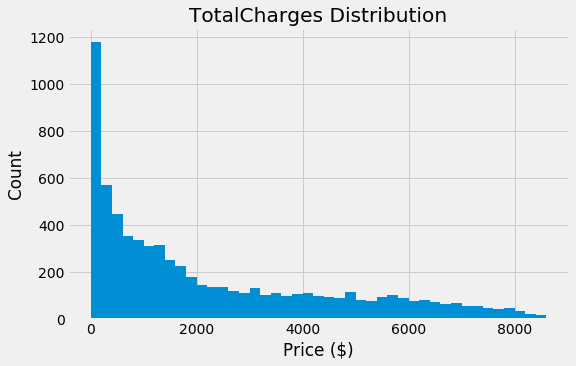

In [10]:
bins = np.arange(0, df['TotalCharges'].max(), 200)

plt.figure(figsize=[8, 5])
plt.hist(data=df, x='TotalCharges', bins=bins)

plt.xlabel('Price ($)')
plt.ylabel('Count')

plt.title('TotalCharges Distribution');

<h3> Since there is a very long tail with the majority of TotalCharges under $2000, I will perform a log transformation on the X axis. </h3>

In [11]:
np.log(df['TotalCharges'].describe())

count    8.858226
mean     7.733377
std      7.726112
min      2.933857
25%      5.995083
50%      7.242422
75%      8.241371
max      9.069330
Name: TotalCharges, dtype: float64

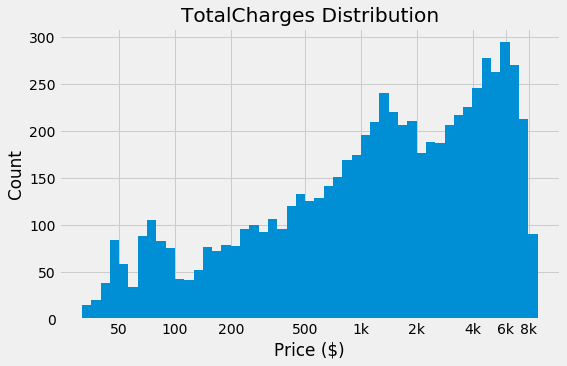

In [12]:
log_binsize = 0.05
bins = 10 ** np.arange(1.5, np.log10(df['TotalCharges'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data=df, x='TotalCharges', bins=bins)

plt.xlabel('Price ($)')
plt.xscale('log')
plt.xticks([5e1, 1e2, 2e2, 5e2, 1e3, 2e3, 4e3, 6e3, 8e3], ['50', '100', '200', '500', '1k', '2k', '4k', '6k', '8k'])

plt.ylabel('Count')

plt.title('TotalCharges Distribution');

> TotalCharges distribution indicates that the majority of customers have spent less than 2000. When plotted on a log scale, the distirbution is roughly bimodal.  The first peak is around 1.5k with the second around 6k.  There is a smooth ramp up from 100 to 2000.

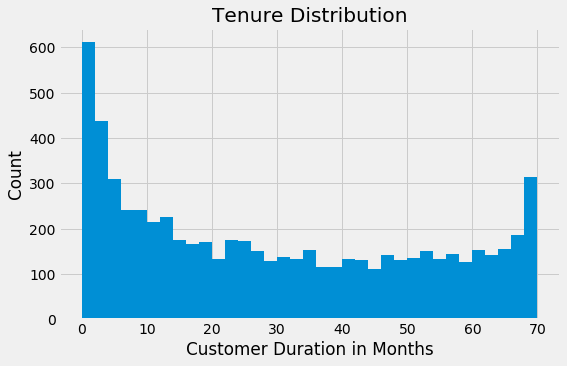

In [13]:
bins = np.arange(0, df['tenure'].max(), 2)

plt.figure(figsize=[8, 5])
plt.hist(data=df, x='tenure', bins=bins)

plt.xlabel('Customer Duration in Months')
plt.ylabel('Count')

plt.title('Tenure Distribution');

> Tenure distribution appears to have a spike in first few months, and a spike at the tail.

In [14]:
# Viewing MonthlyCharges statistics

df.MonthlyCharges.describe()

count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: MonthlyCharges, dtype: float64

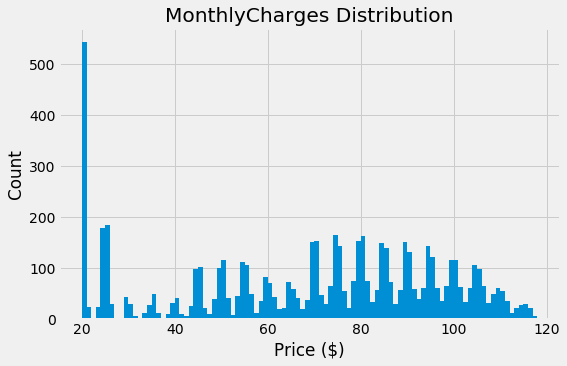

In [15]:
bins = np.arange(20, df['MonthlyCharges'].max(), 1)

plt.figure(figsize=[8, 5])
plt.hist(data=df, x='MonthlyCharges', bins=bins)

plt.xlabel('Price ($)')
plt.ylabel('Count')

plt.title('MonthlyCharges Distribution');

> When providing narrow bins, there is a large spike around 20, and then there are clusters which could indicate prices of certain packages. 

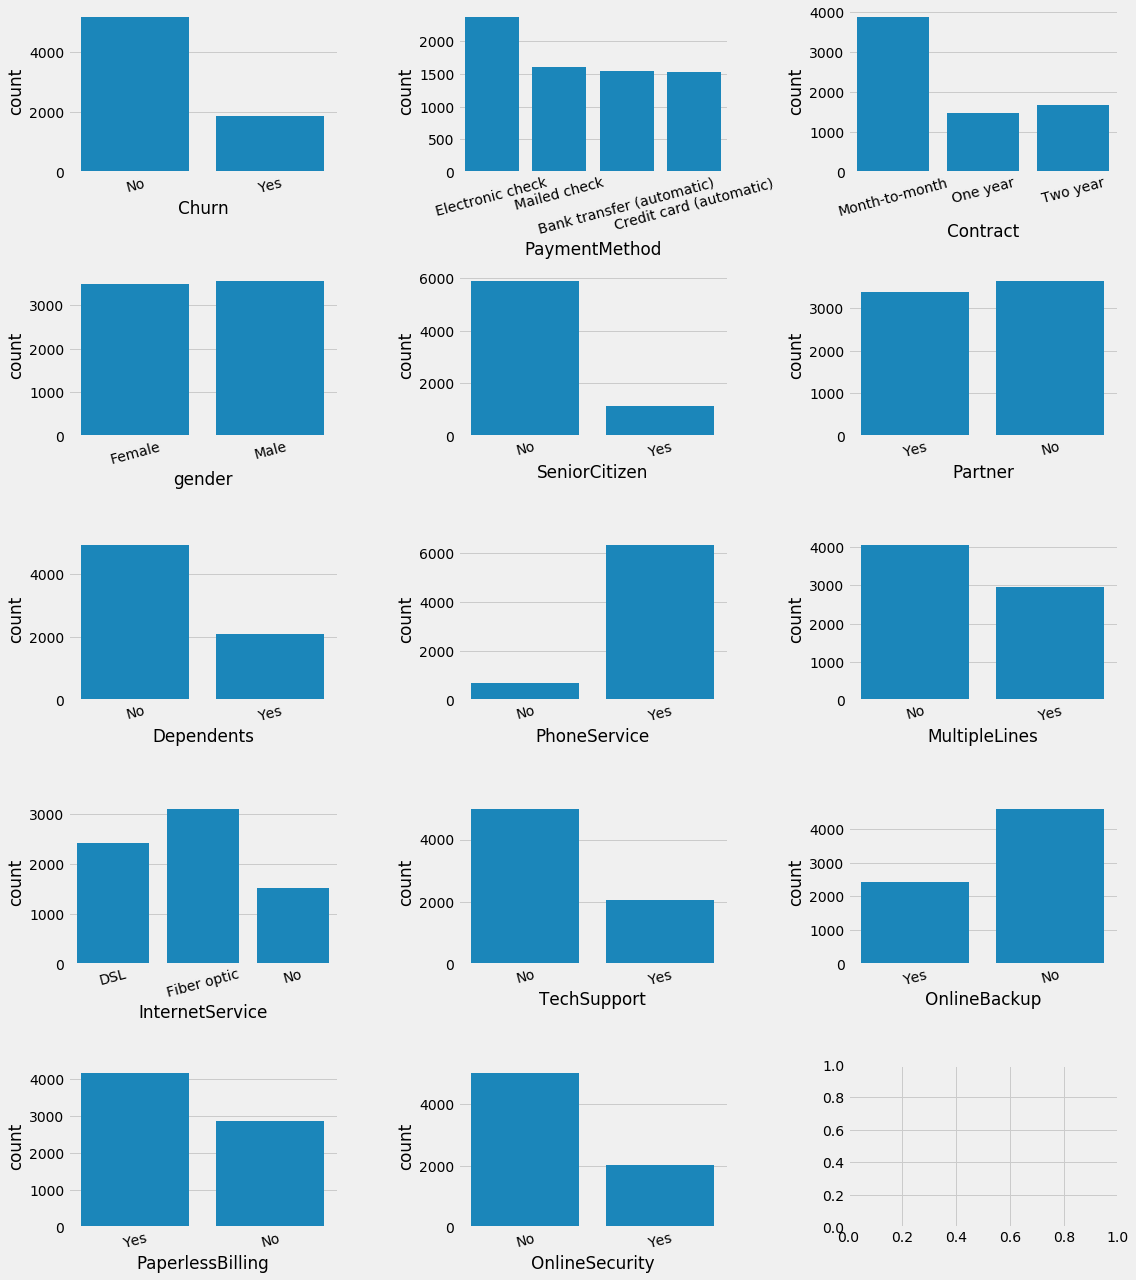

In [17]:
color = sns.color_palette()[0]

cols = ['Churn', 'PaymentMethod', 'Contract', 'gender', 'SeniorCitizen', 'Partner', 
        'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'TechSupport',
        'OnlineBackup', 'PaperlessBilling', 'OnlineSecurity']

fig, ax = plt.subplots(nrows=5, ncols=3, figsize = [16,18])

for ax, col in zip(ax.flatten(), df[cols]):
    sns.countplot(data=df, x=col, color=color, ax=ax)
    plt.sca(ax)
    plt.xticks(rotation=15)

plt.tight_layout();

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> 26.58% of customers churned.  Tenure distribution was very interesting with there being a peak at new customers and another peak at the tail with longtime customers.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Low outliers identified as customers with a tenure of 0 and TotalCharges of 0 were remoted from the data - they accounted for a total of 11 records.  There doesnt appear to be any high outliers.

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

In [18]:
'''
I will bin the months into the following bins

Monthly Bins:
Low - $0-30 per month
Med - $30-65 per month
High - $65-80 per month
Very High - $80+ per month
'''

bins = [0,30,60,100,120]
bin_name = ['Low', 'Med', 'High', 'Very High']

df['monthly_bins'] = pd.cut(df.MonthlyCharges.astype(int), bins=bins, labels=bin_name)

In [19]:
def plot_matrix(mask):
    '''Function to plot a 2x2 subplot for specified mask'''
    color = sns.color_palette()[0]
    mask = mask
    bins = np.arange(0, df[mask].tenure.max(), 2)
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize = [12, 8])
    sns.countplot(data=df[mask], x='PhoneService', color=color, ax=ax[0, 0])
    sns.countplot(data=df[mask], x='InternetService', color=color, ax=ax[0, 1])
    sns.countplot(data=df[mask], x='Churn', color=color, ax=ax[1,0])
    ax[1,1].hist(data=df[mask], x='tenure', bins=bins, color=color);

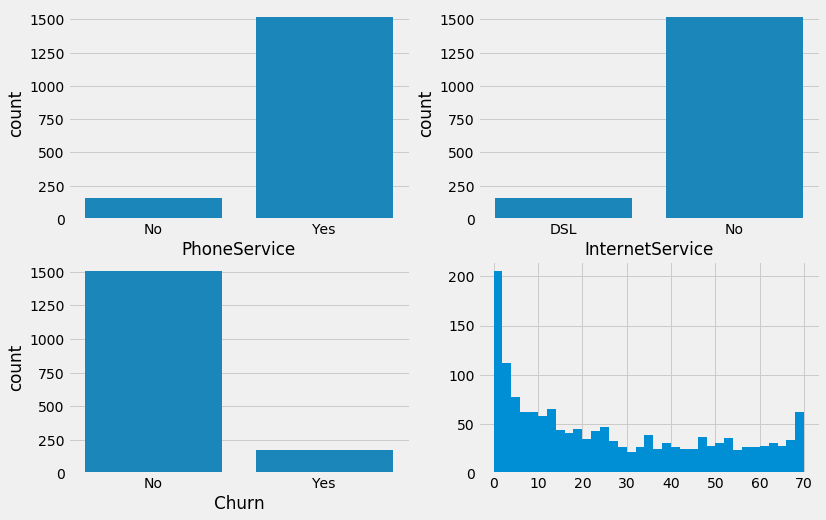

In [20]:
monthly_bill = df['monthly_bins'] == 'Low'

plot_matrix(monthly_bill)

> Customers with a low monthly charge (less than \\$30) appear to churn the least frequent while also having a highly right skewed distribution.

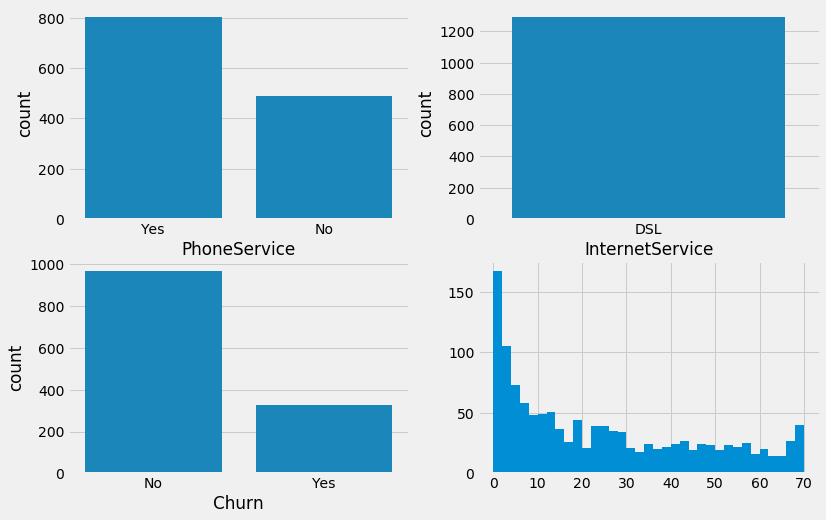

In [38]:
monthly_bill = df['monthly_bins'] == 'Med'

plot_matrix(monthly_bill)

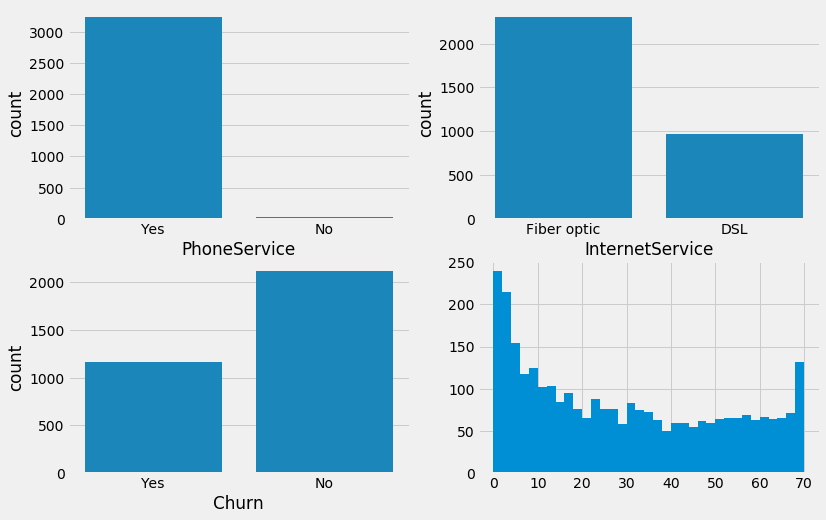

In [39]:
monthly_bill = df['monthly_bins'] == 'High'

plot_matrix(monthly_bill)

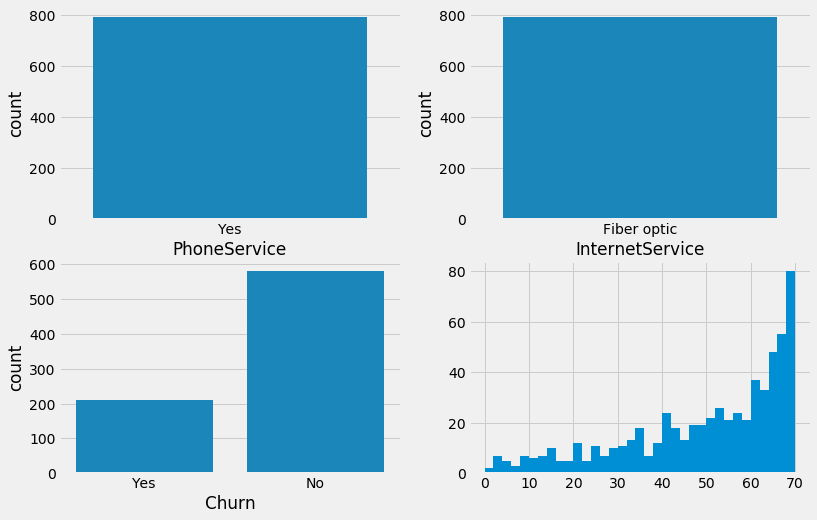

In [41]:
monthly_bill = df['monthly_bins'] == 'Very High'

plot_matrix(monthly_bill)

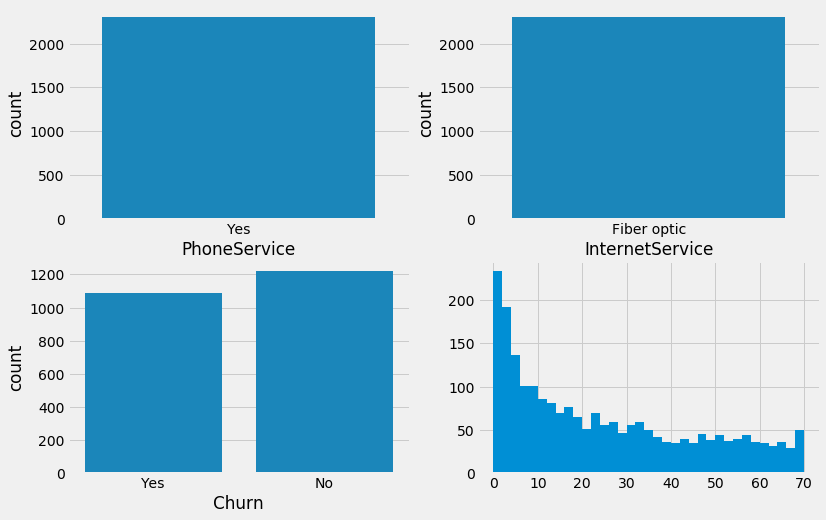

In [21]:
mask = (df['monthly_bins'] == 'High') & (df['InternetService'] != 'DSL')

plot_matrix(mask)

> High monthly charge customers (\\$60 - \\$100) that are also Fiber customers seem to Churn at nearly 50%

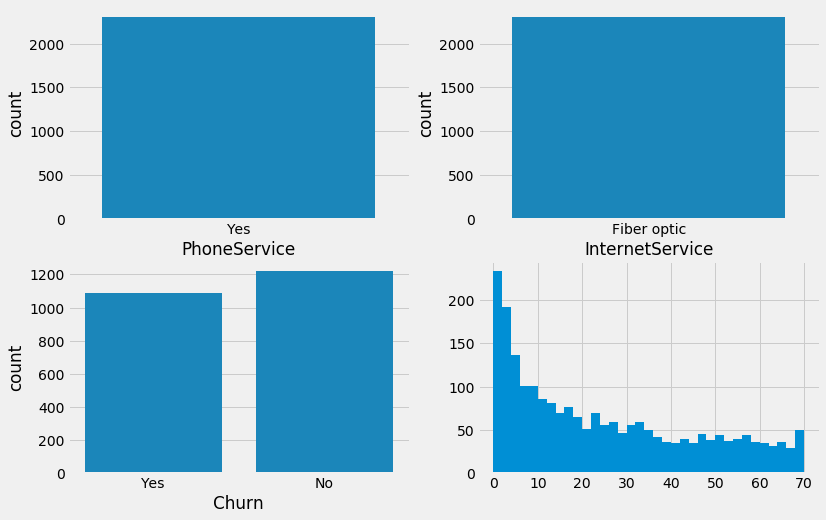

In [45]:
mask = (df['InternetService'] == 'Fiber optic') & (df['monthly_bins'] == 'High')

plot_matrix(mask)

In [46]:
df[mask].Churn.value_counts() / df[mask].shape[0]

No     0.52885
Yes    0.47115
Name: Churn, dtype: float64

> Customers who are binned as high monthly payments (\\$65-\\$85 per month) and are Fiber optic subscribers churn at 47% which is significantly higher than the total population's churn rate of 26%.

In [50]:
df[mask].describe()

,tenure,MonthlyCharges,TotalCharges,tenure_years
count,2305.000000,2305.000000,2305.000000,2305.000000
mean,25.667679,85.996443,2299.510542,1.724078
std,21.840304,9.510413,2042.274048,1.774202
min,1.000000,67.750000,68.500000,0.000000
25%,6.000000,78.850000,485.250000,0.000000
50%,20.000000,86.000000,1725.950000,1.000000
75%,43.000000,94.550000,3842.600000,3.000000
max,72.000000,100.950000,7459.050000,6.000000


In [52]:
df.describe()

,tenure,MonthlyCharges,TotalCharges,tenure_years
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441,2.289534
std,24.545260,30.085974,2266.771362,2.016801
min,1.000000,18.250000,18.800000,0.000000
25%,9.000000,35.587500,401.450000,0.000000
50%,29.000000,70.350000,1397.475000,2.000000
75%,55.000000,89.862500,3794.737500,4.000000
max,72.000000,118.750000,8684.800000,6.000000


> They also on average have a shorter tenure of 1.7 years compared to 2.3 years while maintaining similar total charges.

In [26]:
cat_vars = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
            'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
            'Contract', 'PaperlessBilling', 'PaymentMethod', 'monthly_bins', 'tenure_years']

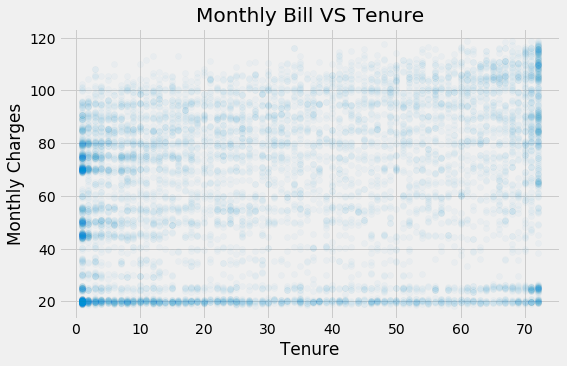

In [27]:
plt.figure(figsize=[8, 5])

plt.scatter(data=df, x='tenure', y='MonthlyCharges', alpha=.03)

plt.xlabel('Tenure')
plt.ylabel('Monthly Charges')

plt.title('Monthly Bill VS Tenure');

#### Here there is an interesting pattern, and very similarly resembes the tenure frequency distribution.  However, we can see that the customers with the longest tenure tend to have a bill that is under \\$30, or over $80.

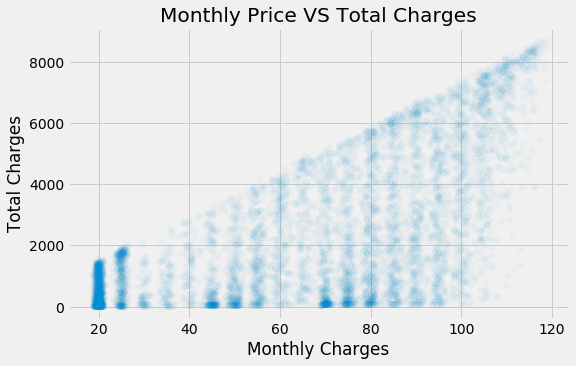

In [28]:
plt.figure(figsize=[8, 5])

plt.scatter(data=df, x='MonthlyCharges', y='TotalCharges', alpha=.03)

plt.xlabel('Monthly Charges')
plt.ylabel('Total Charges')

plt.title('Monthly Price VS Total Charges');

#### Interestingly, it appears that there are some customers between 40 and 80 that have low total charges.  At the same time, those with monthly bills over 100 seem to contribute to higher total charges.

In [29]:
# Churn ratio

df.Churn.value_counts()/df.shape[0]

No     0.734215
Yes    0.265785
Name: Churn, dtype: float64

In [30]:
# Calculate churn ratio for each variable

for category in cat_vars:
    print("Churn = Yes")
    print(df.query('Churn == "Yes"')[category].value_counts() / df[category].value_counts())
    print("Churn = NO")
    print(df.query('Churn == "No"')[category].value_counts() / df[category].value_counts())
    print()

Churn = Yes
Female    0.269595
Male      0.262046
Name: gender, dtype: float64
Churn = NO
Male      0.737954
Female    0.730405
Name: gender, dtype: float64

Churn = Yes
No     0.236503
Yes    0.416813
Name: SeniorCitizen, dtype: float64
Churn = NO
No     0.763497
Yes    0.583187
Name: SeniorCitizen, dtype: float64

Churn = Yes
No     0.329761
Yes    0.197171
Name: Partner, dtype: float64
Churn = NO
No     0.670239
Yes    0.802829
Name: Partner, dtype: float64

Churn = Yes
No     0.312791
Yes    0.155312
Name: Dependents, dtype: float64
Churn = NO
No     0.687209
Yes    0.844688
Name: Dependents, dtype: float64

Churn = Yes
Yes    0.267475
No     0.250000
Name: PhoneService, dtype: float64
Churn = NO
Yes    0.732525
No     0.750000
Name: PhoneService, dtype: float64

Churn = Yes
No     0.250677
Yes    0.286485
Name: MultipleLines, dtype: float64
Churn = NO
No     0.749323
Yes    0.713515
Name: MultipleLines, dtype: float64

Churn = Yes
Fiber optic    0.418928
DSL            0.189983
No

### Churn Ratio by Variable

**gender** - Interestingly, churn within gender is nearly identical to overall churn. <br>
**SeniorCitizen** - Senior Citizens are more likely to churn than non seniors. <br>
**Partner** - Those with partners are less likely to churn than single folks <br>
**Dependents** - Those with dependents are less likely to churn than those without <br>
**PhoneService** - those with phone service are just as likely to churn as overall population <br>
**MultipleLines** - Churn is 3% higher in those with multiple lines <br>
**InternetService** - Fiber Optic customers churn 16% more often than overall population, while DSL and No internet 
service churn less than the population. <br>
**OnlineSecurity** - Customers with online security churn less than the overall population <br>
**OnlineBackup** - Little difference between population <br>
**DeviceProtection** - Litte difference between population <br>
**TechSupport** - Those with tech support tend to churn less than the population <br>
**StreamingTv** - Churn slightly higher rate than population <br>
**StreamingMovies** - Churn at slightly higher rate than population <br>
**Contract** - Month to month churns roughly 17% more often while one year and two year contract holders churn much less frequent <br>
**PaperlessBilling** - Customers without paperless billing tend to churn less often than the population <br>
**PaymentMethod** - Customers paying by electronic check are the most frequent churners while those with automatic payments are the least likely to churn.

In [31]:
# Average Tenure for visual reference

"Mean", df.tenure.mean(), "STD", np.std(df.tenure)

('Mean', 32.421786120591584, 'STD', 24.543514392681953)

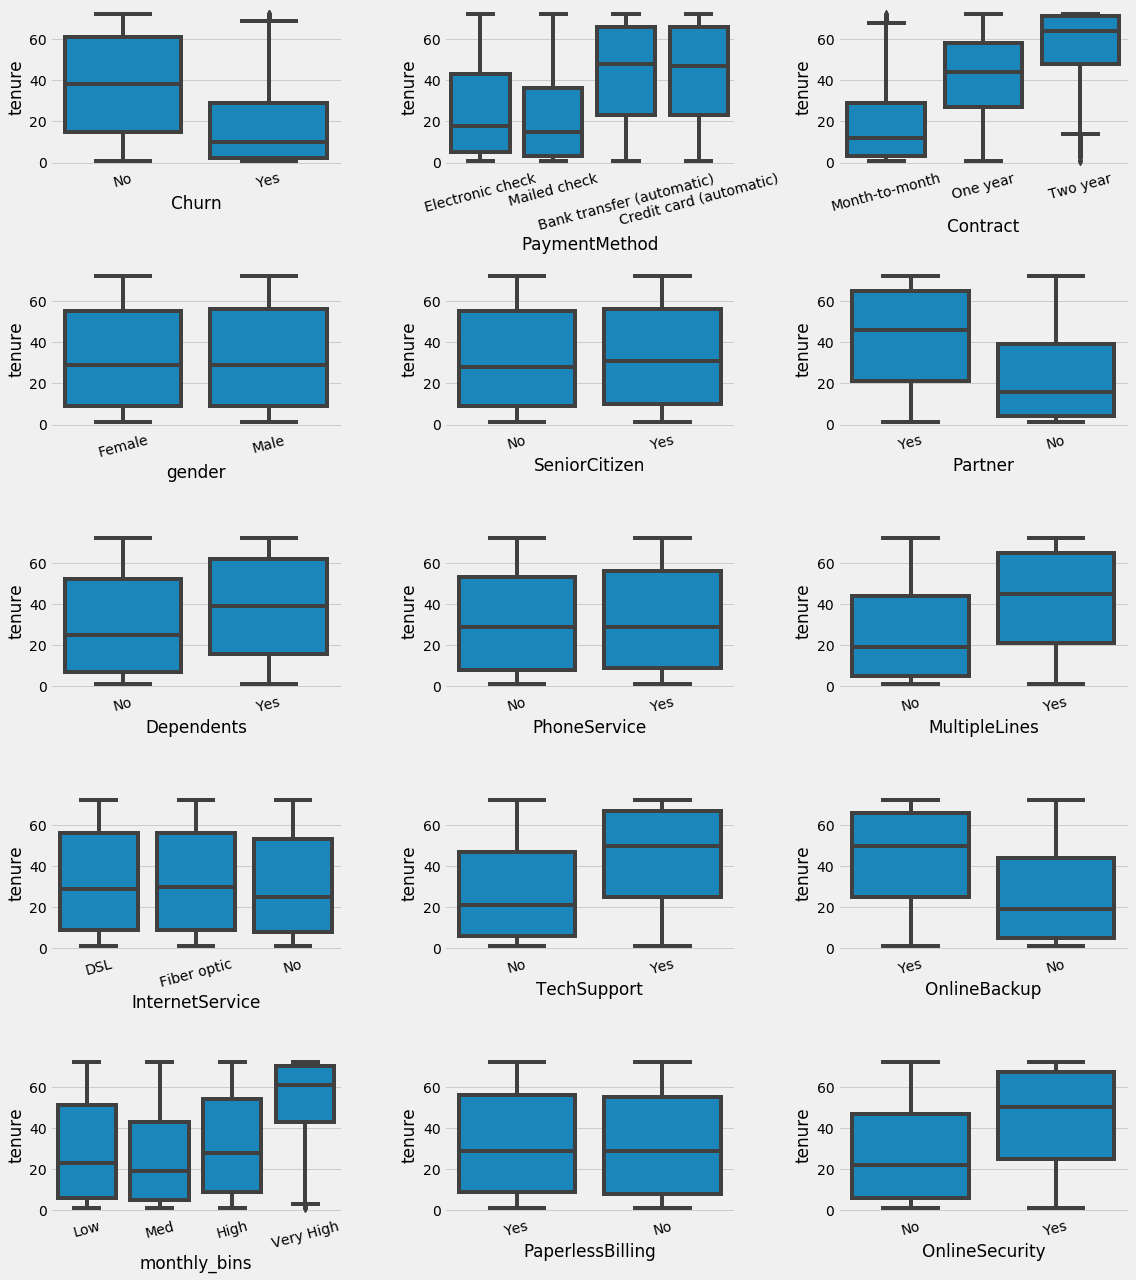

In [32]:
cols = ['Churn', 'PaymentMethod', 'Contract', 'gender', 'SeniorCitizen', 'Partner', 
        'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'TechSupport',
        'OnlineBackup', 'monthly_bins', 'PaperlessBilling', 'OnlineSecurity']

fig, ax = plt.subplots(nrows=5, ncols=3, figsize = [16,18])

for ax, col in zip(ax.flatten(), df[cols]):
    sns.boxplot(data=df, x=col, y='tenure', color=color, ax=ax)
    plt.sca(ax)
    plt.xticks(rotation=15)
    
plt.tight_layout();


In [33]:
df.query('Churn == "Yes"').describe()

,tenure,MonthlyCharges,TotalCharges,tenure_years
count,1869.000000,1869.000000,1869.000000,1869.000000
mean,17.979133,74.441332,1531.796094,1.137507
std,19.531123,24.666053,1890.822994,1.549618
min,1.000000,18.850000,18.850000,0.000000
25%,2.000000,56.150000,134.500000,0.000000
50%,10.000000,79.650000,703.550000,0.000000
75%,29.000000,94.200000,2331.300000,2.000000
max,72.000000,118.350000,8684.800000,6.000000


In [34]:
df.query('Churn == "No"').describe()

,tenure,MonthlyCharges,TotalCharges,tenure_years
count,5163.00000,5163.000000,5163.000000,5163.000000
mean,37.65001,61.307408,2555.344141,2.706566
std,24.07694,31.094557,2329.456984,2.004182
min,1.00000,18.250000,18.800000,0.000000
25%,15.00000,25.100000,577.825000,1.000000
50%,38.00000,64.450000,1683.600000,3.000000
75%,61.00000,88.475000,4264.125000,5.000000
max,72.00000,118.750000,8672.450000,6.000000


**Churn** - Interestingly, the mean tenure for those that do not churn is roughly 3x as long than those that churn.
<br>**PaymentMethod** - Automatic patments tend to have longer mean tenures than non automatic payments with mailed having hte shortest.
<br>**Contract** - As expected, two year contracts have the longest mean tenure followed by one year, while month to month has the shortest.
<br>**gender** - Little to no effect on length of tenure
<br>**SeniorCitizen** - Little to no effect on length of tenure
<br>**Partner** - On average, those with partners have 4x as long tenure
<br>**Dependents** - Those with dependents have roughly 50% increase in mean tenure
<br>**PhoneService** - At glance has little effect on tenure
<br>**MultipleLines** - On average, those with multiple lines have more than 2x as long tenure
<br>**InternetService** - Internet service appears to have little effect on length of tenure though on average, those without interenet have moderately shorter tenure.
<br>**TechSupport** - Customers with TechSupport on average have longer tenure
<br>**OnlineBackup** - Customers with online backup have longer than average tenure
<br>**monthly_bins** - Customers with very high monthly bills have the longest average tenure
<br>**PaperlessBilling** - Little to no effect on length of tenure
<br>**OnlineSecurity** - Customers with online security have longer than average tenure.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> #### Based on the above observations - the most interesting variables related to Tenure are PaymentMethod, Contract, Partner, MultipleLines, TechSupport, and those associated with internet service (OnlineBackup, OnlineSecurity) as their means are significantly above the global mean tenure of 32 months.  WHile not close to 1 STD from the mean, these variables 

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

In [ ]:
cols = ['PaymentMethod', 'Contract', 'SeniorCitizen', 'Partner', 
        'Dependents', 'MultipleLines', 'InternetService', 'TechSupport',
        'OnlineBackup', 'monthly_bins', 'PaperlessBilling', 'OnlineSecurity']

fig, ax = plt.subplots(nrows=4, ncols=3, figsize = [16,18])

for ax, col in zip(ax.flatten(), df[cols]):
    sns.violinplot(data=df, x=col, y='tenure', hue='Churn', split=True, color=color, ax=ax)
    plt.sca(ax)
    plt.xticks(rotation=15)
    plt.legend(loc=10)
    
plt.tight_layout();

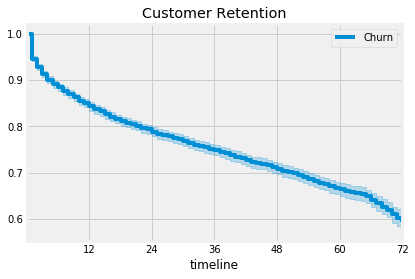

In [95]:
df['encoded_churn'] = df['Churn'].replace({'Yes':1, 'No':0})

time_series = df.tenure
events = df.encoded_churn

## create a kmf object
kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf.fit(time_series, events, label='Churn')

## Create an estimate
kmf.plot()
plt.title('Customer Retention')

plt.xticks(ticks=[12, 24, 36, 48, 60, 72]);

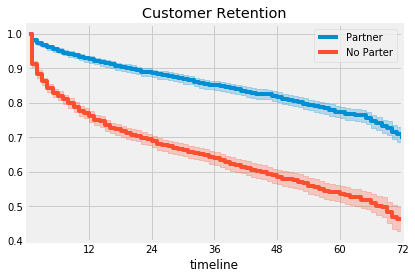

In [99]:
df['encoded_churn'] = df['Churn'].replace({'Yes':1, 'No':0})

T = df.tenure
E = df.encoded_churn

group = df['Partner']
idx = (group == 'Yes')

## create a kmf object
kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf.fit(T[idx], E[idx], label='Partner')

## Create an estimate
a = kmf.plot()

kmf.fit(T[~idx], E[~idx], label='No Parter')
kmf.plot(ax=a)


plt.title('Customer Retention')

plt.xticks(ticks=[12, 24, 36, 48, 60, 72]);

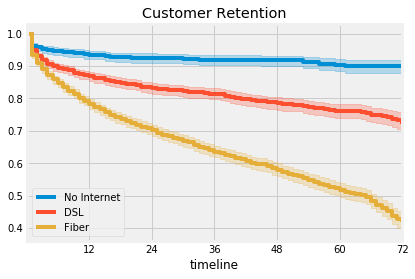

In [101]:
T = df.tenure
E = df.encoded_churn

group = df['InternetService']
no_internet = (group == 'No')
dsl = (group == 'DSL')
fiber = (group == 'Fiber optic')



## create a kmf object
kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf.fit(T[no_internet], E[no_internet], label='No Internet')
a = kmf.plot()

kmf.fit(T[dsl], E[dsl], label='DSL')
kmf.plot(ax=a)

kmf.fit(T[fiber], E[fiber], label='Fiber')
kmf.plot(ax=a)


plt.title('Customer Retention')

plt.xticks(ticks=[12, 24, 36, 48, 60, 72]);

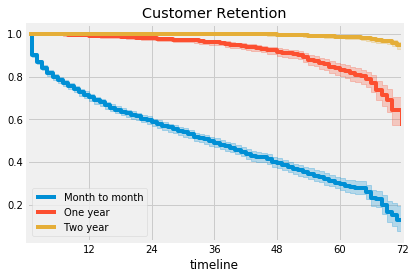

In [105]:
df['encoded_churn'] = df['Churn'].replace({'Yes':1, 'No':0})

T = df.tenure
E = df.encoded_churn

group = df['Contract']
monthly = (group == 'Month-to-month')
one = (group == 'One year')
two = (group == 'Two year')



## create a kmf object
kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf.fit(T[monthly], E[monthly], label='Month to month')
a = kmf.plot()

kmf.fit(T[one], E[one], label='One year')
kmf.plot(ax=a)

kmf.fit(T[two], E[two], label='Two year')
kmf.plot(ax=a)


plt.title('Customer Retention')

plt.xticks(ticks=[12, 24, 36, 48, 60, 72]);

In [ ]:
df['encoded_churn'] = df['Churn'].replace({'Yes':1, 'No':0})

T = df.tenure
E = df.encoded_churn

group = df['Contract']
monthly = (group == 'Month-to-month')
one = (group == 'One year')
two = (group == 'Two year')



## create a kmf object
kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf.fit(T[monthly], E[monthly], label='Month to month')
a = kmf.plot()

kmf.fit(T[one], E[one], label='One year')
kmf.plot(ax=a)

kmf.fit(T[two], E[two], label='Two year')
kmf.plot(ax=a)


plt.title('Customer Retention')

plt.xticks(ticks=[12, 24, 36, 48, 60, 72]);

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!